In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
from sklearn import metrics
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Part 0: Reading the data

Reading the Excel dataset as Pandas DataFrame:

In [2]:
df = pd.read_excel('Fytlyff_DS_Interview_Data.xlsx')
df.head(10)

,Year,Month,Laptop/Desktop,Type_of_Customers?,Coming from,Place_in_India,Level 1,Level 2,Level 3,Level 4
0,2020,Jan,Desktop_Website,Existing_Customer,Came_From_LinkedIn,Bengaluru,NaN,NaN,56892,17178
1,2020,Jan,Desktop_Website,Existing_Customer,Came_From_LinkedIn,Hyderabad,NaN,NaN,41460,11916
2,2020,Jan,Desktop_Website,Existing_Customer,Came_From_LinkedIn,Dehradun,NaN,NaN,55561,19461
3,2020,Jan,Desktop_Website,Existing_Customer,Came_From_LinkedIn,Indore,NaN,NaN,320923,110667
4,2020,Jan,Desktop_Website,Existing_Customer,Came_From_LinkedIn,Pune,NaN,NaN,220937,46033
5,2020,Jan,Desktop_Website,Existing_Customer,Landed_Directly,Bengaluru,NaN,NaN,90241,24229
6,2020,Jan,Desktop_Website,Existing_Customer,Landed_Directly,Hyderabad,NaN,NaN,77630,18502
7,2020,Jan,Desktop_Website,Existing_Customer,Landed_Directly,Dehradun,NaN,NaN,91479,24363
8,2020,Jan,Desktop_Website,Existing_Customer,Landed_Directly,Indore,NaN,NaN,436641,165036
9,2020,Jan,Desktop_Website,Existing_Customer,Landed_Directly,Pune,NaN,NaN,531446,101317


Printing the column names and their datatypes

In [3]:
print(df.dtypes)

Year                    int64
Month                  object
Laptop/Desktop         object
Type_of_Customers?     object
Coming from            object
Place_in_India         object
Level 1               float64
Level 2               float64
Level 3                 int64
Level 4                 int64
dtype: object


Printing the cities of India from which the page was accessed

In [4]:
print(df['Place_in_India'].unique())

['Bengaluru' 'Hyderabad' 'Dehradun' 'Indore' 'Pune']


Printing the columns with missing values

In [5]:
for col in list(df.columns):
    if any(df[col].isna()) == True:
        print(col)

Level 1
Level 2


From the dataset it seems to be a platform for posting jobs/internship/freelancing opportunities for finding candidates online.


Number of new customers who are from Pune and came from LinkedIn

In [6]:
df['Type_of_Customers?'].unique()

array(['Existing_Customer', 'New_Customer'], dtype=object)

In [7]:
df['Coming from'].unique()

array(['Came_From_LinkedIn', 'Landed_Directly', 'Unidentified_Sources'],
      dtype=object)

In [8]:
print("The Number of new customers who are from Pune and came from LinkedIn are:",
      df[ (df['Type_of_Customers?'] == 'New_Customer') & (df['Coming from'] == 'Came_From_LinkedIn') & (df['Place_in_India']=='Pune') ].shape[0])

The Number of new customers who are from Pune and came from LinkedIn are: 72


# Part 1: Data cleaning 

In [9]:
df['Month'].unique()

array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'], dtype=object)

In [10]:
def data_cleaning():
    
    # 1. Creating a column “inc/dec percentage”, which would give the growth/reduction percentage in numbers of level 1 vs level 4 columns.
    df['inc/dec percentage'] = list((df['Level 1']-df['Level 4'])*100/df['Level 1'])
    
    # 2. Replacing all the null values with the average of their respective column in the data.
    level_1_mean = df['Level 1'].mean()
    level_2_mean  = df['Level 2'].mean()
    in_dec_mean = df['inc/dec percentage'].mean()
    df['Level 1'].fillna(value = level_1_mean, inplace = True)
    df['Level 2'].fillna(value = level_2_mean, inplace = True)
    df['inc/dec percentage'].fillna(value = in_dec_mean, inplace = True)
    
    # 3. Replacing Jan with january, Feb with February, Mar with March, and so on using the lambda function.
    months_dict = {'Jan':'January',
                   'Feb':'February',
                   'Mar':'March',
                   'Apr':'April',
                  'Jun':'June',
                  'Jul':'July',
                  'Aug':'August',
                  'Sep':'September',
                  'Oct':'October',
                  'Nov':'November',
                  'Dec':'December'}
    for old, new in months_dict.items():
        df['Month'] = df['Month'].apply(lambda x: x.replace(old, new))
        
    # 4. Replacing “Came_From_LinkedIn” with “From LinkedIn” and “Landed_Directly” with “Direct_traffic” 
    coming_from_dict = {'Came_From_LinkedIn':'From LinkedIn',
                        'Landed_Directly':'Direct_traffic'}
    for old, new in coming_from_dict.items():
        df['Coming from'] = df['Coming from'].apply(lambda x: x.replace(old, new))
    
    return df

In [11]:
data_cleaning()

,Year,Month,Laptop/Desktop,Type_of_Customers?,Coming from,Place_in_India,Level 1,Level 2,Level 3,Level 4,inc/dec percentage
0,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Bengaluru,783870.222017,358215.416281,56892,17178,85.886489
1,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Hyderabad,783870.222017,358215.416281,41460,11916,85.886489
2,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Dehradun,783870.222017,358215.416281,55561,19461,85.886489
3,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Indore,783870.222017,358215.416281,320923,110667,85.886489
4,2020,January,Desktop_Website,Existing_Customer,From LinkedIn,Pune,783870.222017,358215.416281,220937,46033,85.886489
...,...,...,...,...,...,...,...,...,...,...,...
2155,2022,December,Laptop_Website,New_Customer,Unidentified_Sources,Bengaluru,67299.000000,21255.000000,6984,1882,97.203525
2156,2022,December,Laptop_Website,New_Customer,Unidentified_Sources,Hyderabad,430294.000000,156510.000000,46676,16703,96.118235
2157,2022,December,Laptop_Website,New_Customer,Unidentified_Sources,Dehradun,48713.000000,27770.000000,7515,2089,95.711617
2158,2022,December,Laptop_Website,New_Customer,Unidentified_Sources,Indore,593021.000000,310836.000000,161575,78465,86.768597


This is how our dataset looks like after going the cleaning processes as instructed

# Part 2: Descriptive statistics

In [12]:
def descriptive_stats(year=2022, month='January' , Laptop_Desktop='Desktop_Website' , Type_of_Customers='Existing_Customer' , Coming_from='From LinkedIn'):
    
    # 1. Printing minimum values present in all the level-columns
    print ('Minimum value of')
    for col in ['Level 1', 'Level 2', 'Level 3', 'Level 4']:
        print (col,':',df[col].min())
    print("**********************************************************************************************************")
    
    # 2. Prints the maximum value of “Level 2” / “Level 1” among those who came directly via desktop website
    df1 = df[(df['Laptop/Desktop']=='Desktop_Website') & (df['Coming from']=='Direct_traffic')]
    print('Maximum value of Level 2/Level 1 is:',(df1['Level 2']/df1['Level 1']).max())
    print("**********************************************************************************************************")
    
    # 3,4. filter the original dataframe df with the given parameters into  a new dataframe new_df and generate summary stats
    new_df = df[(df['Year']==year) & (df['Month']==month) & (df['Laptop/Desktop']==Laptop_Desktop) & (df['Type_of_Customers?']==Type_of_Customers) & (df['Coming from']==Coming_from)]
    print(new_df.describe())
    print("**********************************************************************************************************")
    
    # 5. Produces a list of all the unique values & data types present in the non-numeric columns 
    non_numeric = df.select_dtypes(include=['object']).columns.tolist()
    print('Unique values of')
    for col in non_numeric:
        print(col,':',df[col].unique())
    

In [13]:
descriptive_stats()

Minimum value of
Level 1 : 24567.0
Level 2 : 8425.0
Level 3 : 3761
Level 4 : 766
**********************************************************************************************************
Maximum value of Level 2/Level 1 is: 0.7938173377045838
**********************************************************************************************************
         Year        Level 1        Level 2        Level 3       Level 4  \
count     5.0       5.000000       5.000000       5.000000      5.000000   
mean   2022.0  783870.222017  358215.416281   76257.400000  28851.600000   
std       0.0       0.000000       0.000000   39513.620883  15311.711638   
min    2022.0  783870.222017  358215.416281   33812.000000  13808.000000   
25%    2022.0  783870.222017  358215.416281   39599.000000  18461.000000   
50%    2022.0  783870.222017  358215.416281   86085.000000  21931.000000   
75%    2022.0  783870.222017  358215.416281   93522.000000  41016.000000   
max    2022.0  783870.222017  358215.4162

# Part 3: Prescriptive statistics

1. Top 3 places in India  on the basis of column “Level 4” for the year 2020 and 2022 separately 

In [14]:
df2 = df[(df['Year']==2020) | (df['Year']==2022)]
d1 = df2.groupby(['Year','Place_in_India']).agg(Sum_of_Level_4=('Level 4','sum'))
d1['Rank by column "Level 4"'] = d1.groupby('Year').rank(method='dense',ascending=False)
d1 =d1.reset_index()
pd.concat([d1.head(5).sort_values(by='Rank by column "Level 4"').head(3),d1.tail(5).sort_values(by='Rank by column "Level 4"').head(3)],axis=0)

,Year,Place_in_India,Sum_of_Level_4,"Rank by column ""Level 4"""
3,2020,Indore,20092071,1.0
4,2020,Pune,11039977,2.0
2,2020,Hyderabad,5156066,3.0
8,2022,Indore,15104408,1.0
9,2022,Pune,11208722,2.0
7,2022,Hyderabad,8211936,3.0


2. 

In [15]:
d2 = df.groupby(['Year','Place_in_India']).agg(Sum_of_Level_1=('Level 1','sum'),Sum_of_Level_2=('Level 2','sum'),Sum_of_Level_3=('Level 3','sum'),Sum_of_Level_4=('Level 4','sum'))
d2.reset_index()
d2['sum of level 2/sum of level 1'] = d2['Sum_of_Level_2']/d2['Sum_of_Level_1']
d2['sum of level 3/sum of level 1']= d2['Sum_of_Level_3']/d2['Sum_of_Level_1']
d2['sum of level 4/sum of level 1']=d2['Sum_of_Level_4']/d2['Sum_of_Level_1']
d2.drop(columns=['Sum_of_Level_1','Sum_of_Level_2','Sum_of_Level_3','Sum_of_Level_4'],inplace = True)
d2

sum of level 2/sum of level 1  \
Year Place_in_India                                  
2020 Bengaluru                            0.488079   
     Dehradun                             0.483189   
     Hyderabad                            0.501703   
     Indore                               0.585207   
     Pune                                 0.502248   
2021 Bengaluru                            0.453393   
     Dehradun                             0.436285   
     Hyderabad                            0.439948   
     Indore                               0.461700   
     Pune                                 0.363878   
2022 Bengaluru                            0.441282   
     Dehradun                             0.419564   
     Hyderabad                            0.457508   
     Indore                               0.499384   
     Pune                                 0.390387   

                     sum of level 3/sum of level 1  \
Year Place_in_India                                  
2020 Bengaluru                            0.109296   
     Dehradun                             0.101910   
     Hyderabad                            0.136220   
     Indore                               0.321899   
     Pune                                 0.266550   
2021 Bengaluru                            0.090450   
     Dehradun                             0.081112   
     Hyderabad                            0.148135   
     Indore                               0.258978   
     Pune                                 0.164717   
2022 Bengaluru                            0.101524   
     Dehradun                             0.102348   
     Hyderabad                            0.206666   
     Indore                               0.313373   
     Pune                                 0.191877   

                     sum of level 4/sum of level 1  
Year Place_in_India                                 
2020 Bengaluru                            0.046336  
     Dehradun                             0.049106  
     Hyderabad                            0.065812  
     Indore                               0.152649  
     Pune                                 0.096418  
2021 Bengaluru                            0.042744  
     Dehradun                             0.031764  
     Hyderabad                            0.074894  
     Indore                               0.115071  
     Pune                                 0.069406  
2022 Bengaluru                            0.048503  
     Dehradun                             0.033521  
     Hyderabad                            0.069364  
     Indore                               0.090095  
     Pune                                 0.059378

3. Bottom 3 places in India  on the basis of column Level 4/Level 1 for the year 2021 and 2022 separately.

In [16]:
d2 = d2.reset_index()
d2.drop(columns=['sum of level 2/sum of level 1','sum of level 3/sum of level 1'],inplace=True)
df3 = d2[(d2['Year']==2021) | (d2['Year']==2022)]
pd.concat([df3.head(5).sort_values(by='sum of level 4/sum of level 1', ascending = False).tail(3), df3.tail(5).sort_values(by='sum of level 4/sum of level 1', ascending = False).tail(3)],axis=0)

,Year,Place_in_India,sum of level 4/sum of level 1
9,2021,Pune,0.069406
5,2021,Bengaluru,0.042744
6,2021,Dehradun,0.031764
14,2022,Pune,0.059378
10,2022,Bengaluru,0.048503
11,2022,Dehradun,0.033521


4. Finding out which place in India is having “Level 4” value greater than 150000 most of the times

In [17]:
a1 = df.groupby('Place_in_India')['Level 4'].apply(lambda x: x[x>150000].count())
print(a1.idxmax(),'is having Level 4 value > 150000 max. no. of times with a frequency of',a1.max())

Indore is having Level 4 value > 150000 max. no. of times with a frequency of 143


5. Checking which place in India is having least number of existing customers

In [18]:
a2 = df.groupby('Place_in_India')['Type_of_Customers?'].apply(lambda x: x[x == 'Existing_Customer'].count())
a2

Place_in_India
Bengaluru    216
Dehradun     216
Hyderabad    216
Indore       216
Pune         216
Name: Type_of_Customers?, dtype: int64

All cities are having equal no. of existing customers

# Part 4: Simple Machine learning questions

In [19]:
# Creating a new column Date with dates in a standard format
date = []
month_as_word = list(df['Month'].unique())
month_as_index = np.arange(1,13,1)
month_dict = {}
for i in range(12):
    month_dict[month_as_word[i]] = month_as_index[i]
for i in df.index:
    date.append(str(month_dict[df['Month'][i]])+'/'+str(df['Year'][i]))
df['Date'] = date
df['Date'] = pd.to_datetime(df['Date'])

In [20]:
# Searching for best parameters
data = df[(df['Laptop/Desktop']=='Desktop_Website') & (df['Type_of_Customers?']=='Existing_Customer') & (df['Coming from']=='From LinkedIn') & (df['Place_in_India']=='Bengaluru')]
data = data.set_index('Date')
stepwise_fit = auto_arima(data['Level 4'], suppress_warnings=True)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -335.967
Date:                Thu, 29 Dec 2022   AIC                            677.934
Time:                        06:18:17   BIC                            682.685
Sample:                    01-01-2020   HQIC                           679.592
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4631.9902   1281.956      3.613      0.000    2119.404    7144.577
ar.L1          0.6803      0.083      8.195      0.000       0.518       0.843
sigma2      7.431e+06      0.634   1.17e+07      0.000    7.43e+06    7.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):                 6.34
Prob(Q):                              0.54   Prob(JB):                         0.04
Heteroskedasticity (H):               5.57   Skew:                             0.78
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.47e+22. Standard errors may be unstable.
"""

In [21]:
#fitting the training data(2020-22) on the ARIMA model with best parameters
train  = data['Level 4']
model = ARIMA(train, order= (1,0,0))
model = model.fit()

In [22]:
def predict_future(year=2022, month='January' , Laptop_Desktop='Desktop_Website' , Type_of_Customers='Existing_Customer' , Coming_from='From LinkedIn', Place_in_India='Bengaluru'):
    
    sns.set(font_scale = 1.5)
    
    # 1. Predict “Level 4” future values for the next 1 year
    data = df[(df['Laptop/Desktop']==Laptop_Desktop) & (df['Type_of_Customers?']==Type_of_Customers) & (df['Coming from']==Coming_from) & (df['Place_in_India']==Place_in_India)]
    data = data.set_index('Date')
    date_time_dict  ={'January':'01',
                     'February':'02',
                     'March':'03',
                     'April':'04',
                     'May':'05',
                     'June':'06',
                     'July':'07',
                     'August':'08',
                     'September':'09',
                     'October':'10',
                     'November':'11',
                     'December':'12'}
    start_date  = str(year)+'-'+date_time_dict[month]+'-'+'01'
    if year == 2022:
        end_date = '2022-12-01'
    else:
        end_date = str(year+1)+'-'+date_time_dict[month]+'-'+'01'
    next_1_year_data  = data.loc[start_date:end_date]
    fig,ax = plt.subplots(figsize=(15,6))
    predictions  = model.predict(start_date,end_date)
    predictions.plot(label='Predicted')
    next_1_year_data['Level 4'].plot(label='Actual')
    plt.ylabel('Level 4')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title('Actual values vs. ARIMA model predictions for Level 4:')
    plt.plot()
    
    # 2. Generating the MAPE and RMSE of 'Level 4' predictions for the year 2022, 2021 & 2020
    for year in [2020,2021,2022]:
        yearwise_data  = data[data['Year']==year]['Level 4']
        yearwise_pred = model.predict(str(year)+'-01-01',str(year)+'-12-01')
        mape = metrics.mean_absolute_percentage_error(yearwise_data, yearwise_pred)
        mse = metrics.mean_squared_error(yearwise_data, yearwise_pred)
        rmse = np.sqrt(mse) 
        print('Year',year)
        print("MAPE:",np.round(mape,3))
        print("RMSE:", np.round(rmse,3))
        print('---------------------')
        
        
    # 3. Line graph of the level 4 actual numbers from 2020-2022 and the predicted numbers for 2023
    fig,ax = plt.subplots(figsize=(15,6))
    data['Level 4'].plot(kind='line')
    pred_2023 = model.predict('2022-11-01','2023-12-01')
    pred_2023.plot(kind='line')
    plt.ylabel('Level 4')

Year 2020
MAPE: 0.064
RMSE: 1422.604
---------------------
Year 2021
MAPE: 0.166
RMSE: 3327.536
---------------------
Year 2022
MAPE: 0.223
RMSE: 3042.265
---------------------


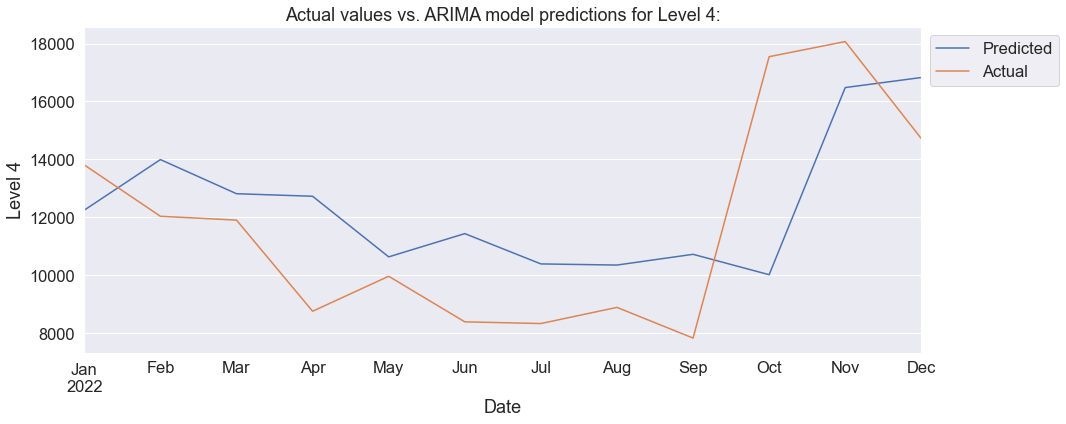

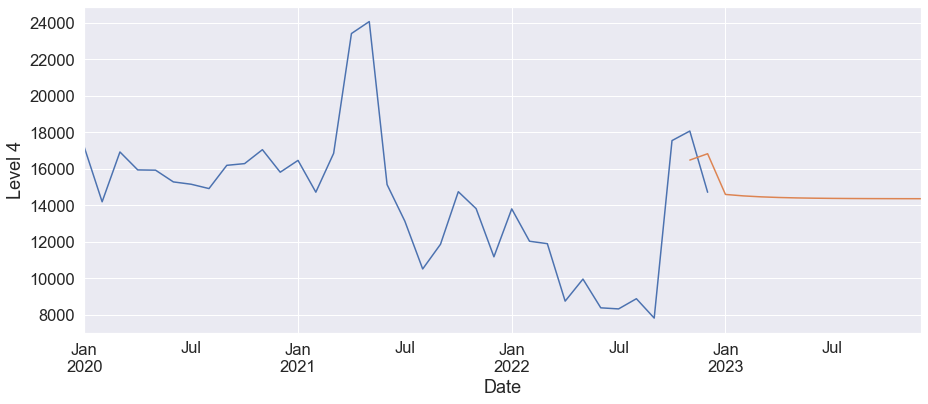

In [23]:
predict_future()

# Part 5: Visualization

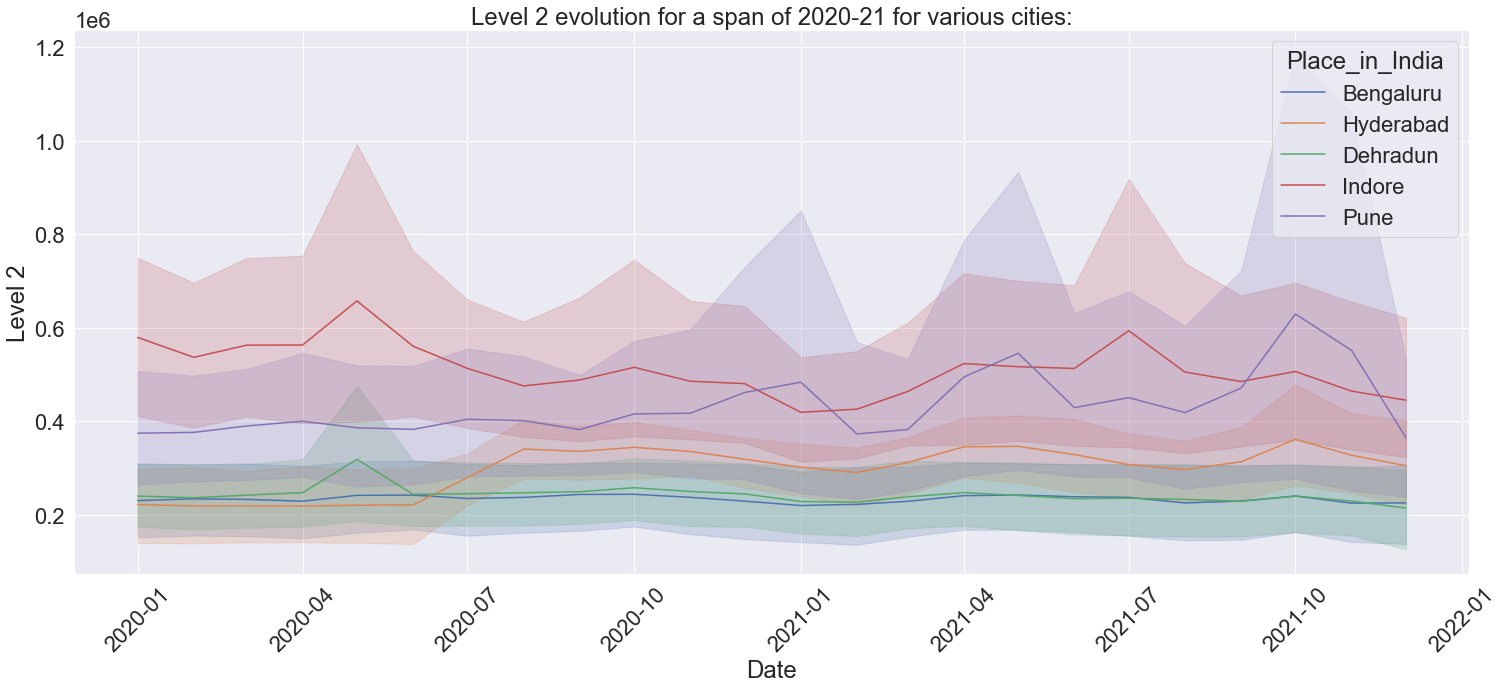

In [24]:
# 1.
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(data = df[(df['Year']==2020) | (df['Year']==2021)], x='Date', y = 'Level 2', hue = 'Place_in_India')
plt.title('Level 2 evolution for a span of 2020-21 for various cities:')
ax.tick_params(axis='x', rotation=45)

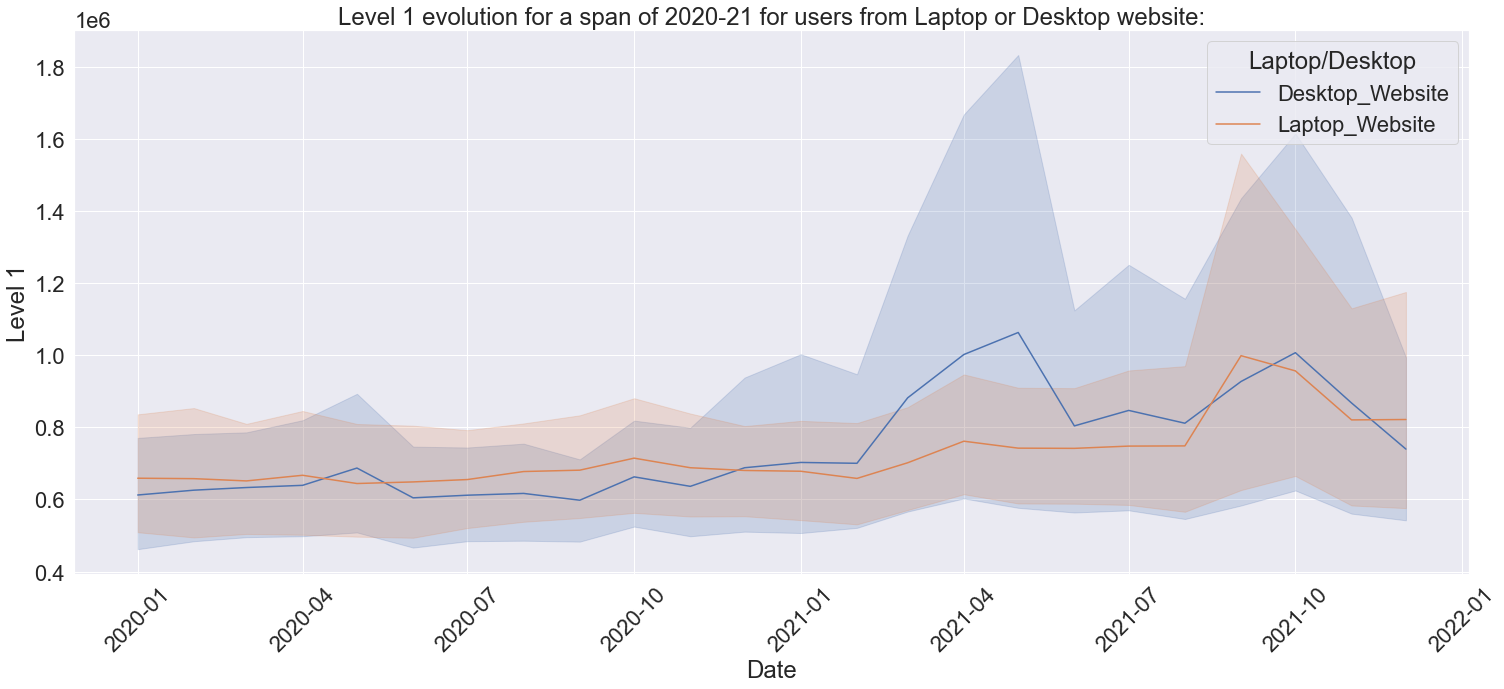

In [25]:
# 2.
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(data = df[(df['Year']==2020) | (df['Year']==2021)], x='Date', y = 'Level 1', hue = 'Laptop/Desktop')
plt.title('Level 1 evolution for a span of 2020-21 for users from Laptop or Desktop website:')
ax.tick_params(axis='x', rotation=45)

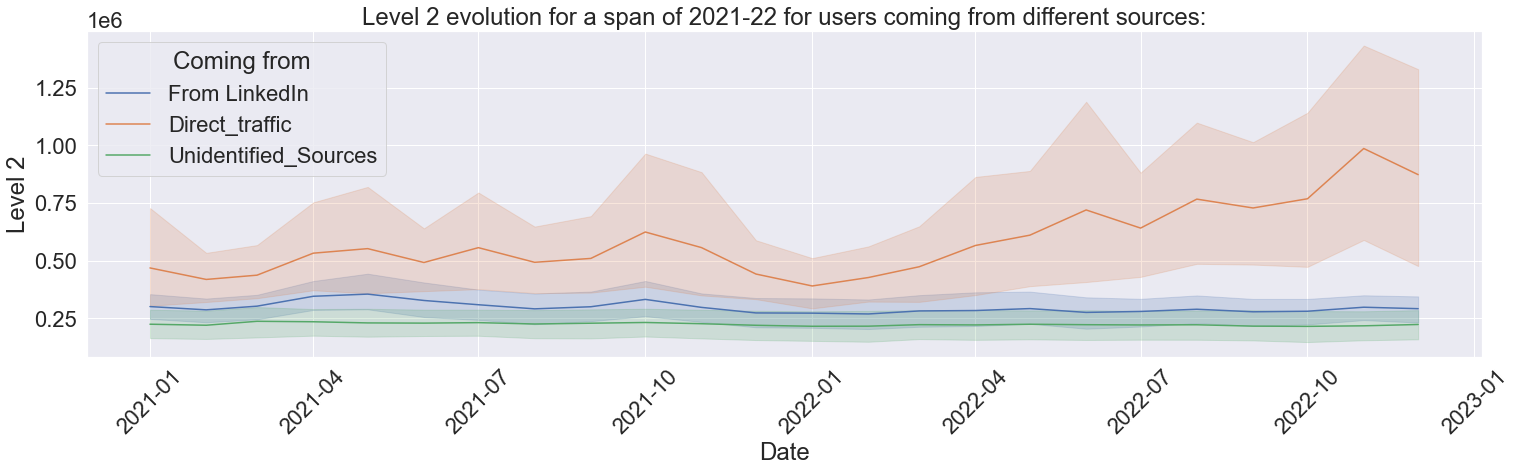

In [26]:
# 3.
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(25,6))
sns.lineplot(data = df[(df['Year']==2021) | (df['Year']==2022)], x='Date', y = 'Level 2', hue = 'Coming from')
plt.title('Level 2 evolution for a span of 2021-22 for users coming from different sources:')
ax.tick_params(axis='x', rotation=45)


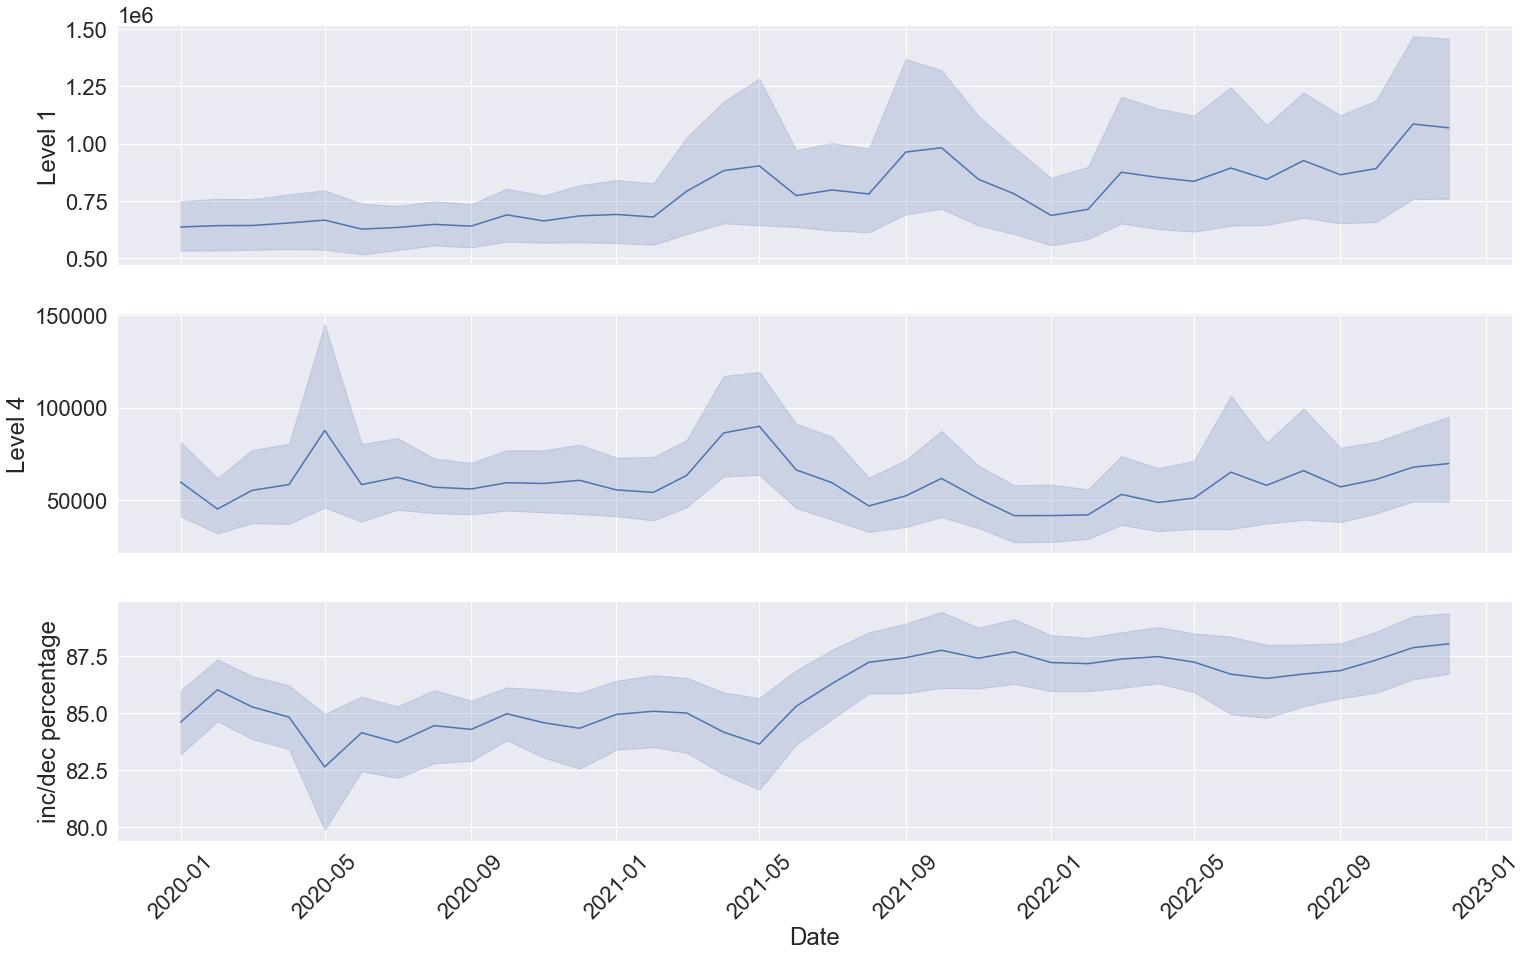

In [27]:
# 4.
sns.set(font_scale=2)
fig, axes = plt.subplots(3,1,figsize=(25,15), sharex=True)
sns.lineplot(data = df, x='Date', y = 'Level 1', ax= axes[0] )
sns.lineplot(data = df, x='Date', y = 'Level 4', ax= axes[1] )
sns.lineplot(data = df, x='Date', y = 'inc/dec percentage',ax= axes[2] )
axes[2].tick_params(axis='x', rotation=45)

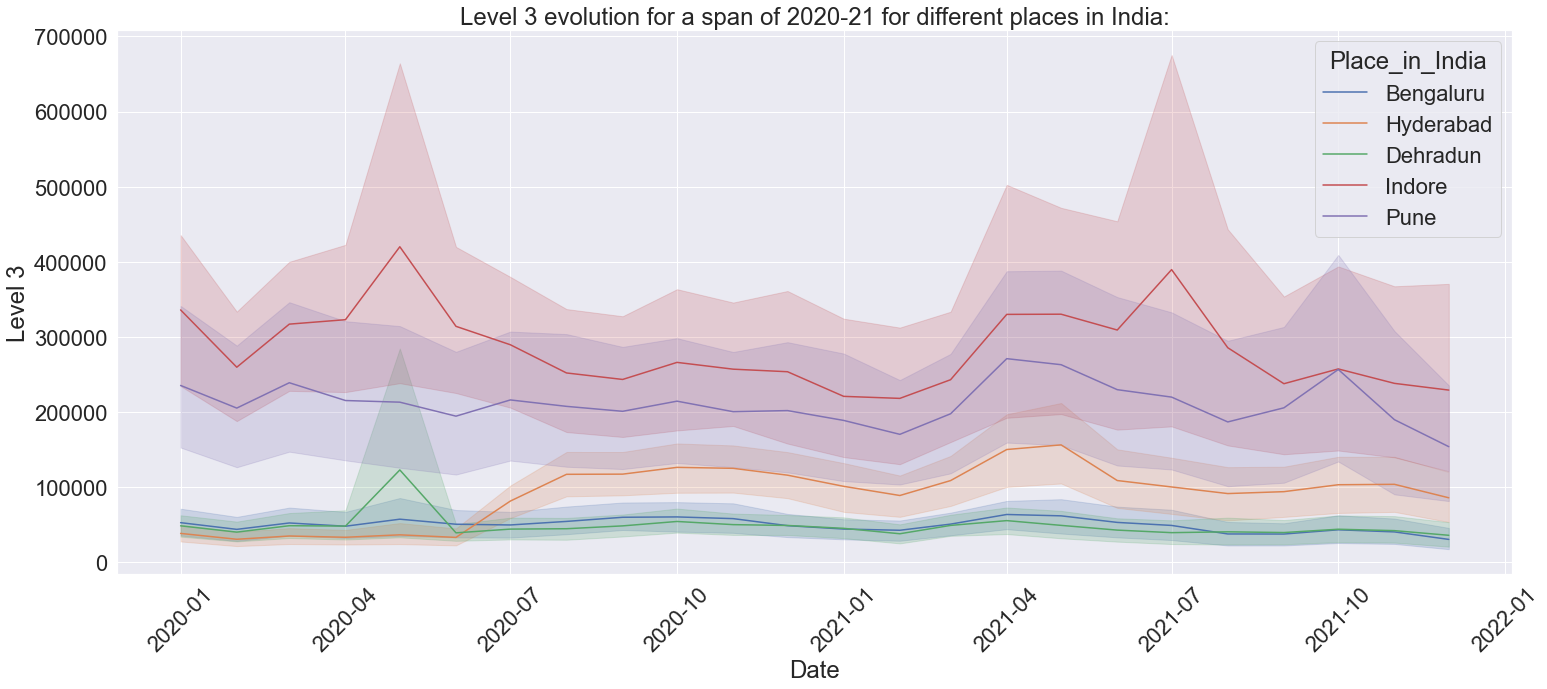

In [28]:
# 5.
sns.set(font_scale=2)
fig, ax = plt.subplots(figsize=(25,10))
sns.lineplot(data = df[(df['Year']==2020) | (df['Year']==2021)], x='Date', y = 'Level 3', hue = 'Place_in_India')
plt.title('Level 3 evolution for a span of 2020-21 for different places in India:')
ax.tick_params(axis='x', rotation=45)

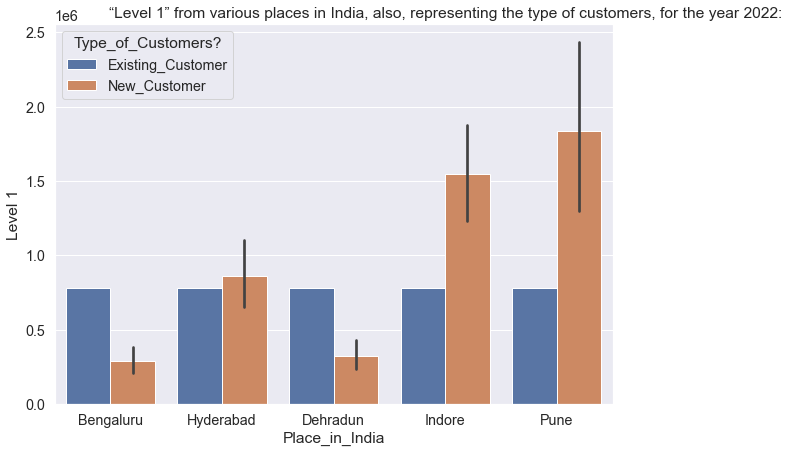

In [29]:
# 6.
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data = df[df['Year']==2022], x= 'Place_in_India', y = 'Level 1', hue = 'Type_of_Customers?')
plt.title('“Level 1” from various places in India, also, representing the type of customers, for the year 2022:')
ttl = ax.title
ttl.set_position([.7,1.5])
plt.show()
